# Medical Appointment No Shows
Why do 30% of patients miss their scheduled appointments?

https://www.kaggle.com/joniarroba/noshowappointments#

**Author: Małgorzata Stolarska**

[under-construction]

### Table of Contents

* [Data Dictionary](#data_dictionary)
* [Imports, parameters and initializations](#imports)
* [Data loading and initial checks](#loading)
* [Initial preprocessing](#preprocessing)
* [Split data set into training, validation and test parts](#split)
* [Data review on the training set](#data_review)
* [Data transformation](#data_transformation)
    * [Visualization of correlations](#visualization)
    * [Pipeline building](#pipeline)
* [Data transformation](#data_transformation)
* [Model building and evaluation](#models)
    * [Auxiliary classes and function](#classes)
    * [...](#...)
* [Final evaluation](#final)
* [Summary](#summary)

## Data Dictionary <a class="anchor" id="data_dictionary"></a>
- **PatientId**: Identification of a patient
- **AppointmentID**: Identification of each appointment
- **Gender**: 
Male or Female (female is the greater proportion, woman takes way more care of they health in comparison to man).
- **ScheduledDay**: 
The day of the actuall appointment, when they have to visit the doctor.
- **AppointmentDay**: 
The day someone called or registered the appointment, this is before appointment of course.
- **Age**: 
How old is the patient.
- **Neighbourhood**: 
Where the appointment takes place.
- **Scholarship**: True of False 
- **Hipertension**: True or False
- **Diabetes**: True or False
- **Alcoholism**: True or False
- **Handcap**: Number of disabilities (0 = a person without disability, 1 and more = a person with disabilities)
- **SMS_received**: Messages sent to the patient.
- **No-show (target variable)**: True or False.

## Imports, parameters and initializations <a class="anchor" id="imports"></a>

In [ ]:
!python --version

Python 3.7.11


In [ ]:
!pip install --upgrade neptune-client 
!pip install --upgrade neptune

     |████████████████████████████████| 252 kB 29.7 MB/s 
     |████████████████████████████████| 829 kB 42.7 MB/s 
     |████████████████████████████████| 52 kB 1.9 MB/s 
     |████████████████████████████████| 170 kB 54.1 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 129 kB 60.1 MB/s 
     |████████████████████████████████| 67 kB 5.9 MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.10.5-py2.py3-none-any.whl size=432248 sha256=adb25e5859ed383e09f1bb812c896b1095fe78f460214c2be27a85b4cd8d1f83
  Stored in directory: /root/.cache/pip/wheels/2c/df/30/816b183e4f808e85973d136e9e0d051a9fc5f2c47debe3d459
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=528fe5c9257b77f7f0aefcb978caf7ed391438af834def2a372a0f3712f739e4
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.

In [ ]:
!pip install opendatasets --upgrade

In [ ]:
!pip install imblearn --upgrade

In [ ]:
!pip install catboost --upgrade

     |████████████████████████████████| 67.4 MB 28 kB/s 


In [ ]:
# !pip install numpy --upgrade
# !pip install pandas --upgrade

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import opendatasets as od  # library for downloading datasets from online sources like Kaggle and Google Drive 

from sklearn import __version__ as sklearn_version
from sklearn import set_config as sklearn_set_config
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, make_scorer, f1_score, precision_score, recall_score
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score, confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.pipeline import Pipeline  # for imbalanced data
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
from imblearn import __version__ as imblearn_version
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from keras import metrics
from datetime import time, date, datetime, timezone, timedelta

import neptune
# import neptune.new as neptun

# freeze randomness:
from numpy.random import seed
from tensorflow.random import set_seed
seed(12) 
set_seed(123)

# Sklearn options 
# sklearn_set_config(display='diagram') # interactive diagrams for pipelines

# Pandas options
pd.set_option('display.float_format', '{:.4f}'.format) 
pd.set_option('display.max_columns', None) 
pd.set_option("max_colwidth", None)

# Versions
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("sklearn:", sklearn_version)
print("imblearn", imblearn_version)
print("neptune:", neptune.__version__)

from warnings import simplefilter
# future warnings show only once
simplefilter(action='once', category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


pandas: 1.1.5
numpy: 1.19.5
sklearn: 0.22.2.post1
imblearn 0.4.3
neptune: 0.10.5


In [ ]:
# Kaggle authorization data: {'username': '...', 'key': '...'}
with open('kaggle.json') as f:
   kaggle_authorization = json.load(f)

# Neptune authorization data: {'project': '...', 'token': '...'}
with open('neptune_no_shows.json') as f:
   neptune_authorization = json.load(f)

print(kaggle_authorization['username'])
print(neptune_authorization['project'])

magorzatastolarska
malgo.stolarska/Med-Appointments-No-Shows


In [ ]:
# Token should be set in the system settings or directly below
PROJECT_NAME = 'DataWorkshop-Foundation/Predicting-cancellation-of-visit' 
#PROJECT_NAME = neptune_authorization['project'] 
MY_TOKEN = neptune_authorization['token']
project = neptune.init(project_qualified_name = PROJECT_NAME, api_token=MY_TOKEN)
project

Project(DataWorkshop-Foundation/Predicting-cancellation-of-visit)

In [ ]:
kaggle_url = "https://www.kaggle.com/joniarroba/noshowappointments"
filename = r"./username/noshowappointments/KaggleV2-May-2016.csv"
path = r"."  # for saving data
author = "Małgorzata Stolarska"  # for Neptune

## Data loading and initial checks <a class="anchor" id="loading"></a>

In [ ]:
# Upload directly from Kaggle:
od.download(kaggle_url, *kaggle_authorization)

100%|██████████| 2.40M/2.40M [00:00<00:00, 97.7MB/s]

In [ ]:
df = pd.read_csv(filename)
print("Shape:", df.shape)
print("Duplicated:", df.duplicated().sum())
df.head()

Shape: (110527, 14)
Duplicated: 0


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296.0000,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438.0000,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951.0000,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174.0000,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183.0000,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [ ]:
# Check types
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [ ]:
# Check target (ratio)
df["No-show"].value_counts(normalize=True, dropna=False)

No    0.7981
Yes   0.2019
Name: No-show, dtype: float64

In [ ]:
min_appointment_day = df.AppointmentDay.min()
print(f"AppointmentDay: [{min_appointment_day[:10]}, {df.AppointmentDay.max()[:10]}],",
      f"days = {(pd.to_datetime(df.AppointmentDay.max()) - pd.to_datetime(df.AppointmentDay.min())).days}")

AppointmentDay: [2016-04-29, 2016-06-08], days = 40


## Initial preprocessing <a class="anchor" id="preprocessing"></a>

Assuming that the solution would be deployed in a production environment, I would be able to obtain data about the patient's history, such as the number of previous visits and the number of missed visits. I prepare such data below, i.e. for each appointment, I count data of previous appointments of the same patient.

The data don't include the time of appointments. In the case of a production solution, it should be added, but here I assume that sorting by AppointmentDay returns appointments in the correct orders.

In [ ]:
def medicalAppointmentsDataPrepare(df, days_to_count=14):
    """
    Preparing Medical Appointments data
    """
    _window = "".join([str(days_to_count), "D"])
    print("Window:", _window)

    _df = df.copy()    

    # Change types
    _df = _df.astype(dtype={"PatientId":"int64", 
                            "ScheduledDay":"datetime64", 
                            "AppointmentDay":"datetime64"})  
        
    # Change Yes/No to 1/0
    _df["No-show"] = _df["No-show"].map({"Yes":1, "No":0}, na_action='ignore').astype("int64") 

    # Add time from ScheduledDay to AppointmentDay 
    # (we need a clear order of visits for technical reasons; this column will be removed later)
    _df["_appDateTime"] = pd.to_datetime(_df['AppointmentDay'].astype(str) + ' ' +  \
                                         _df['ScheduledDay'].dt.time.astype(str)) 

    # Sort by patient and appointment day 
    _df.sort_values(by=["PatientId","_appDateTime"], inplace=True, ignore_index=True)
    _df.reset_index(inplace=True)

    # Create technical columns
    _df["_appPrevCount"] = _df.groupby("PatientId").agg({"AppointmentID":"cumcount"})
    _df["_appDay_NS0"] = _df.loc[_df["No-show"]==0].AppointmentDay 
    _df["_appDay_NS1"] = _df.loc[_df["No-show"]==1].AppointmentDay

    # Set _lastShow and _lastNoShow
    _lastAppDay_NS0 = _df.groupby("PatientId")["_appDay_NS0"].shift(1).rename("_lastShow")
    _lastAppDay_NS1 = _df.groupby("PatientId")["_appDay_NS1"].shift(1).rename("_lastNoShow")
    _df = _df.join(_lastAppDay_NS0, how="left").join(_lastAppDay_NS1, how="left")
    # Fill technical date 1970-01-01 for all first appointments
    _df.loc[_df._appPrevCount==0 ,"_lastShow"] = pd.Timestamp(0)
    _df.loc[_df._appPrevCount==0 ,"_lastNoShow"] = pd.Timestamp(0)
    # Fill NaN-s using ffill method by using the last known date
    _df.loc[:,"_lastShow"].fillna(method="ffill", inplace=True)
    _df.loc[:,"_lastNoShow"].fillna(method="ffill", inplace=True)

    # Count waiting time
    _df["_waitingTime"] = (_df["AppointmentDay"].dt.date - _df["ScheduledDay"].dt.date).dt.days        
    _df.loc[_df._waitingTime < 0, "_waitingTime"] = 0
    # Count time from last successful visit 
    _df["_lastShowTime"] = (_df["AppointmentDay"].dt.date - _df["_lastShow"].dt.date).dt.days   
    # Set maximum value = days_to_count+1     
    _df.loc[_df._lastShowTime > days_to_count, "_lastShowTime"] = days_to_count + 1
    # Count time from last no-show
    _df["_lastNoShowTime"] = (_df["AppointmentDay"].dt.date - _df["_lastNoShow"].dt.date).dt.days
    # Set maximum value = days_to_count+1
    _df.loc[_df._lastNoShowTime > days_to_count, "_lastNoShowTime"] = days_to_count + 1

    # Count sequences of recent No-show values 
    _df['_group'] = _df.groupby(["PatientId", (_df['No-show'] != _df['No-show'].shift(1)).cumsum()]).cumcount() + 1
    # Set 0 for all No-shows == 0
    _df.loc[_df["No-show"] == 0, '_group'] = 0
    # Take a value from previous record
    _df["_sumRecentNoShows"] = _df['_group'].shift(1).fillna(0).astype(int)
    # Correct value if the previous record was for a different patient
    _df.loc[_df["_sumRecentNoShows"] > _df["_appPrevCount"], '_sumRecentNoShows'] = _df["_appPrevCount"]

    # For rolling with xD window, we need a DatatimeIndex
    _df_dt_index = _df.set_index("_appDateTime").sort_index().copy()
    _roll = _df_dt_index.groupby("PatientId").rolling(window=_window, min_periods=1, center=False, closed="left")
    _sumAppoint_xD = pd.DataFrame(_roll["No-show"].count()).reset_index().rename(columns={"No-show":"_sumAppoint_xD"})
    _sumNoShows_xD = pd.DataFrame(_roll["No-show"].sum()).reset_index().rename(columns={"No-show":"_sumNoShows_xD"})
    _df = _df.join(_sumAppoint_xD["_sumAppoint_xD"].fillna(0).astype(int)).\
              join(_sumNoShows_xD["_sumNoShows_xD"].fillna(0).astype(int))
    
    # Remove technical columns
    _df.drop(columns=["index","_appDateTime","_appPrevCount","_appDay_NS0","_appDay_NS1",
                      "_lastShow","_lastNoShow","_group"], inplace=True)
  
    return _df

In [ ]:
days_to_count = 14 
df_new = medicalAppointmentsDataPrepare(df=df ,days_to_count=days_to_count)

Window: 14D


In [ ]:
# PatientId to test
df_new.groupby("PatientId").agg({"No-show":["count","sum"]}).sort_values(by=("No-show","count"), ascending=False).\
       head(40).tail(10)

No-show    
                  count sum
PatientId                  
36994987339512       23   3
37994336685892       22   3
17798942295934       21   4
496777386375         21   2
725983755516         21   6
9715135545613        20  11
787697428886813      20   4
6383698598534        20   6
54376659453918       20   3
69322187574939       20   0

In [ ]:
# Test
cols = ["PatientId", "ScheduledDay", "AppointmentDay", "No-show"] + [col for col in df_new.columns if col[0] == "_"]
df_new.query("PatientId == 9715135545613")[cols]

,PatientId,ScheduledDay,AppointmentDay,No-show,_waitingTime,_lastShowTime,_lastNoShowTime,_sumRecentNoShows,_sumAppoint_xD,_sumNoShows_xD
45137,9715135545613,2016-05-04 16:05:24,2016-05-04,1,0,15,15,0,0,0
45138,9715135545613,2016-05-04 16:08:03,2016-05-04,1,0,15,0,1,1,1
45139,9715135545613,2016-05-04 16:10:18,2016-05-04,1,0,15,0,2,2,2
45140,9715135545613,2016-05-06 19:12:17,2016-05-06,0,0,15,2,3,3,3
45141,9715135545613,2016-05-10 13:31:46,2016-05-10,0,0,4,6,0,4,3
45142,9715135545613,2016-05-10 13:36:24,2016-05-10,0,0,0,6,0,5,3
45143,9715135545613,2016-05-11 07:47:24,2016-05-11,1,0,1,7,0,6,3
45144,9715135545613,2016-05-11 07:55:08,2016-05-11,1,0,1,0,1,7,4
45145,9715135545613,2016-05-11 16:09:40,2016-05-11,1,0,1,0,2,8,5
45146,9715135545613,2016-05-12 18:49:20,2016-05-12,0,0,2,1,3,9,6


In [ ]:
df_new.query("PatientId == 17798942295934")[cols]

,PatientId,ScheduledDay,AppointmentDay,No-show,_waitingTime,_lastShowTime,_lastNoShowTime,_sumRecentNoShows,_sumAppoint_xD,_sumNoShows_xD
49453,17798942295934,2016-04-27 07:00:57,2016-04-29,0,2,15,15,0,0,0
49454,17798942295934,2016-04-28 06:42:04,2016-05-02,0,4,3,15,0,1,0
49455,17798942295934,2016-05-02 06:56:06,2016-05-04,0,2,2,15,0,2,0
49456,17798942295934,2016-05-04 07:27:04,2016-05-06,0,2,2,15,0,3,0
49457,17798942295934,2016-05-05 06:53:21,2016-05-09,0,4,3,15,0,4,0
49458,17798942295934,2016-05-09 07:00:47,2016-05-11,0,2,2,15,0,5,0
49459,17798942295934,2016-05-04 10:46:13,2016-05-12,0,8,1,15,0,6,0
49460,17798942295934,2016-05-11 06:37:06,2016-05-13,0,2,1,15,0,7,0
49461,17798942295934,2016-05-12 06:37:10,2016-05-16,0,4,3,15,0,7,0
49462,17798942295934,2016-05-16 07:04:55,2016-05-18,0,2,2,15,0,6,0


In [ ]:
# Reduce dataset by removing records from first "days_to_count" days
new_min_appointment_day = pd.to_datetime(df_new.AppointmentDay.min() + pd.DateOffset(days=days_to_count))
df_reduced = df_new.loc[pd.to_datetime(df_new.AppointmentDay) >= new_min_appointment_day]

df_reduced.AppointmentDay.min(), df_reduced.AppointmentDay.max(), \
(pd.to_datetime(df_reduced.AppointmentDay.max()) - pd.to_datetime(df_reduced.AppointmentDay.min())).days

(Timestamp('2016-05-13 00:00:00'), Timestamp('2016-06-08 00:00:00'), 26)

In [ ]:
df_new[cols].describe()

,PatientId,No-show,_waitingTime,_lastShowTime,_lastNoShowTime,_sumRecentNoShows,_sumAppoint_xD,_sumNoShows_xD
count,110527.0000,110527.0000,110527.0000,110527.0000,110527.0000,110527.0000,110527.0000,110527.0000
mean,147496265710394.0938,0.2019,10.1838,12.0061,14.0747,0.1147,0.7459,0.1202
std,256094920291739.0625,0.4014,15.2549,5.2032,3.1500,0.4537,2.1617,0.4295
min,39217.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,4172614444192.0000,0.0000,0.0000,10.0000,15.0000,0.0000,0.0000,0.0000
50%,31731838713978.0000,0.0000,4.0000,15.0000,15.0000,0.0000,0.0000,0.0000
75%,94391720898175.0000,0.0000,15.0000,15.0000,15.0000,0.0000,1.0000,0.0000
max,999981631772427.0000,1.0000,179.0000,15.0000,15.0000,17.0000,33.0000,9.0000


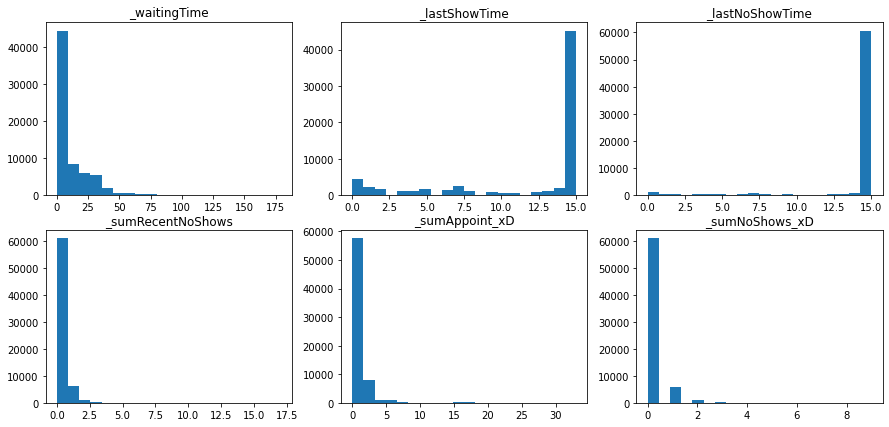

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(15,7))
i, j = 0, 0
for col in [c for c in cols if c[0] == "_"]:
    axs[i,j].hist(df_reduced[col], bins=20) 
    axs[i,j].set_title(col) 
    i = (i if j < 2 else i+1)
    j = (j+1 if j < 2 else 0)    
plt.show()

#### [Save data]

In [ ]:
# Dump data to pickle
with open("/".join([path, "prepared_NoShows.obj"]), "wb") as fp:
    pickle.dump(df_reduced, fp)

In [ ]:
# Read data from pickle 
with open("/".join([path, "prepared_NoShows.obj"]), 'rb') as fp:
    df_reduced = pickle.load(fp)

## Split data set into training, validation and test parts <a class="anchor" id="split"></a>

In [ ]:
# First, split patients:

# Choose unique patients
patients = pd.DataFrame(df_reduced["PatientId"].unique(), columns=["PatientId"])

# Split patients into training and test subsets
p_train, p_test = train_test_split(patients, test_size=0.3, random_state=33)

# Split patients from the test data into validation and test subsets
p_valid, p_test = train_test_split(p_test, test_size=0.5, random_state=33)

In [ ]:
# Create training data
X_train = df_reduced.merge(p_train, on="PatientId", how="inner")
y_train = X_train["No-show"]
X_train.drop(columns="No-show", inplace=True)

In [ ]:
# Create validation data
X_valid = df_reduced.merge(p_valid, on="PatientId", how="inner")
y_valid = X_valid["No-show"]
X_valid.drop(columns="No-show", inplace=True)

In [ ]:
# Create test data
X_test = df_reduced.merge(p_test, on="PatientId", how="inner")
y_test = X_test["No-show"]
X_test.drop(columns="No-show", inplace=True)

In [ ]:
# Shape of data sets
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_valid.shape, y_valid.shape)
print("Test set:", X_test.shape, y_test.shape)

Training set: (48162, 19) (48162,)
Validation set: (10238, 19) (10238,)
Test set: (10244, 19) (10244,)


In [ ]:
y_train.value_counts(normalize=True, dropna=False)

0   0.8019
1   0.1981
Name: No-show, dtype: float64

In [ ]:
y_valid.value_counts(normalize=True, dropna=False)

0   0.8020
1   0.1980
Name: No-show, dtype: float64

In [ ]:
y_test.value_counts(normalize=True, dropna=False)

0   0.7933
1   0.2067
Name: No-show, dtype: float64

## Data review on the training set <a class="anchor" id="data_review"></a>

In [ ]:
X_train.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,_waitingTime,_lastShowTime,_lastNoShowTime,_sumRecentNoShows,_sumAppoint_xD,_sumNoShows_xD
0,39217,5751990,F,2016-05-31 10:56:41,2016-06-03,44,PRAIA DO SUÁ,0,0,0,0,0,0,3,15,15,0,0,0
1,43741,5760144,M,2016-06-01 14:22:58,2016-06-01,39,MARIA ORTIZ,0,0,1,0,0,0,0,15,15,0,0,0
2,5628261,5680449,M,2016-05-10 11:58:18,2016-05-13,13,PARQUE MOSCOSO,0,0,0,0,0,0,3,15,15,0,0,0
3,52168938,5704816,F,2016-05-16 16:42:19,2016-05-16,28,JARDIM DA PENHA,0,0,0,0,0,0,0,15,15,0,0,0
4,52168938,5607220,F,2016-04-20 11:22:15,2016-05-17,28,JARDIM DA PENHA,0,0,0,0,0,0,27,1,15,0,1,0


In [ ]:
X_train.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,_waitingTime,_lastShowTime,_lastNoShowTime,_sumRecentNoShows,_sumAppoint_xD,_sumNoShows_xD
count,48162.0000,48162.0000,48162.0000,48162.0000,48162.0000,48162.0000,48162.0000,48162.0000,48162.0000,48162.0000,48162.0000,48162.0000,48162.0000,48162.0000,48162.0000
mean,147228602396700.2812,5702759.4963,37.3201,0.0996,0.1937,0.0700,0.0288,0.0226,0.2896,10.6476,11.7675,14.0098,0.1451,0.9303,0.1410
std,255685840780355.2500,65304.2216,23.0524,0.2995,0.3952,0.2551,0.1672,0.1625,0.4536,15.7673,5.2456,3.1808,0.5367,2.6334,0.4702
min,39217.0000,5134197.0000,-1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,4197364929749.7500,5679362.2500,18.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8.0000,15.0000,0.0000,0.0000,0.0000
50%,32124224805938.5000,5713749.5000,37.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,15.0000,15.0000,0.0000,0.0000,0.0000
75%,94311952186456.0000,5747559.5000,56.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,16.0000,15.0000,15.0000,0.0000,1.0000,0.0000
max,999968578354866.0000,5790484.0000,115.0000,1.0000,1.0000,1.0000,1.0000,4.0000,1.0000,179.0000,15.0000,15.0000,17.0000,33.0000,9.0000


In [ ]:
# Columns with NaN
with pd.option_context("display.max_rows", X_train.shape[1]):
    print(X_train.isna().any()[X_train.isna().any()])
    
# No NaNs in data

Series([], dtype: bool)


In [ ]:
# Counted values in columns
for col in X_train.columns:
    if X_train[col].dtype in [object, str]:
      print("Column:", col)
      with pd.option_context("display.max_rows", 20):
          print(X_train[col].value_counts(dropna=False))
      print("-" * 30)

Column: Gender
F    31457
M    16705
Name: Gender, dtype: int64
------------------------------
Column: Neighbourhood
JARDIM CAMBURI                 3411
MARIA ORTIZ                    2491
RESISTÊNCIA                    1972
JARDIM DA PENHA                1644
SANTA MARTHA                   1479
                               ... 
PONTAL DE CAMBURI                30
ILHA DO BOI                      17
ILHAS OCEÂNICAS DE TRINDADE       2
ILHA DO FRADE                     2
AEROPORTO                         2
Name: Neighbourhood, Length: 80, dtype: int64
------------------------------


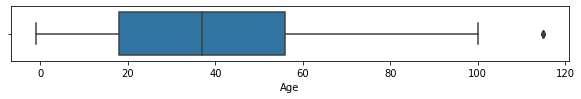

In [ ]:
plt.figure(figsize=(10,1))
ax = sns.boxplot(x=X_train["Age"])
plt.show()

#### No-shows over time

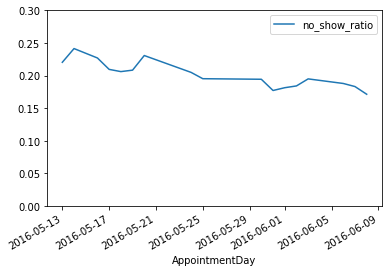

In [ ]:
# Number of no-shows per day
X_y_train = X_train.join(y_train)
no_shows_in_time = X_y_train.loc[X_y_train["No-show"] == 1].groupby(["AppointmentDay"])["AppointmentID"].count()
appointment_in_time = X_y_train.groupby(["AppointmentDay"])["AppointmentID"].count()
# Ratio of no-shows to all appointments per day
no_shows_in_time = pd.DataFrame(no_shows_in_time/appointment_in_time).reset_index()
no_shows_in_time.rename(columns={"AppointmentID":"no_show_ratio"}, inplace=True)

no_shows_in_time.plot(x="AppointmentDay", ylim=(0,0.3))

## Data transformation <a class="anchor" id="data_transformation"></a>

In [ ]:
class MedicalAppointmentsTransformer(BaseEstimator, TransformerMixin):
    """
    Transformation of Medical Appointments data
    columns - which columns to use
    """
    
    def __init__(self, neighbourhood_min_count=200, max_recent_no_shows=3, columns=None): 
        self.neighbourhood_min_count = neighbourhood_min_count
        self.max_recent_no_shows = max_recent_no_shows  
        self.columns = columns      
        pass
            
    
    def fit(self, X, y=None):   
        X_y = X.join(y)
        
        # Neighbourhoods with numerous visits
        neighbourhoods_counts = X_y["Neighbourhood"].value_counts()
        self.neighbourhoods_ = neighbourhoods_counts[neighbourhoods_counts > self.neighbourhood_min_count]
        # Combine small clinics into one (the model will not learn to predict for small classes)
        X_y["_Neighbourhood"] = X_y["Neighbourhood"].apply(lambda x: x if x in self.neighbourhoods_ else "OTHER")
        no_shows = X_y.loc[X_y["No-show"] == 1].groupby(["_Neighbourhood"])["AppointmentID"].count()
        # Ratio of no-shows to all appointments for each neighbourhood
        self.neighbourhood_ratio_ = pd.DataFrame(no_shows/X_y.groupby(["_Neighbourhood"])["AppointmentID"].count()).\
                                    reset_index().rename(columns={"AppointmentID":"_NeighbourhoodRatio"})  
        
        # Number of no-shows per day of week    
        X_y["_DayOfWeek"] = X_y["AppointmentDay"].dt.day_name()
        no_shows = X_y.loc[X_y["No-show"] == 1].groupby(["_DayOfWeek"])["AppointmentID"].count()
        # Ratio of no-shows to all appointments on each day of week
        self.day_of_week_ratio_ = pd.DataFrame(no_shows/X_y.groupby(["_DayOfWeek"])["AppointmentID"].count()).\
                                  reset_index().rename(columns={"AppointmentID":"_DayOfWeekRatio"})      
        
        # Mean of age
        self.age_ = int(X_y["Age"].mean())

        # Moda of gender
        self.gender_ = X_y["Gender"].mode()[0]

        # Const for handcap
        self.handcap_ = 0
        
        return self

    
    def transform(self, X, y=None):
        X_copy = X.copy()   
        
        # Combine small clinics into one (the model will not learn to predict for small classes)
        X_copy["_Neighbourhood"] = X_copy["Neighbourhood"].apply(lambda x: x if x in self.neighbourhoods_ else "OTHER")
        # Ratio of no-shows to all appointments for each clinic (the column _NeighbourhoodRatio will be added)    
        X_copy = X_copy.merge(self.neighbourhood_ratio_, on="_Neighbourhood", how="left").drop(columns="_Neighbourhood")        
        
        # Ratio of no-shows to all appointments on each day of week (the column _DayOfWeekRatio will be added)    
        X_copy["_DayOfWeek"] = X_copy["AppointmentDay"].dt.day_name()
        X_copy = X_copy.merge(self.day_of_week_ratio_, on="_DayOfWeek", how="left").drop(columns="_DayOfWeek")

        # No-shows ratio in the last 7 days
        X_copy.loc[X_copy["_sumAppoint_xD"] > 0, "_NoShowsRatio_xD"] = X_copy["_sumNoShows_xD"]/X_copy["_sumAppoint_xD"]
        X_copy["_NoShowsRatio_xD"].fillna(0, inplace=True)
        
        # _sumRecentNoShow is  strongly correlated with _NoShowsRatio_xD and we transform it to _RecentNoShows
        # (additionally, this variable is burdened with an error because is not limited by period days_to_count)
        X_copy["_RecentNoShows"] = X_copy["_sumRecentNoShows"]
        X_copy.loc[X_copy["_sumRecentNoShows"] > self.max_recent_no_shows, "_RecentNoShows"] = self.max_recent_no_shows

        # Correct the age by taking the median
        X_copy["_Age"] = X_copy["Age"]
        X_copy.loc[(X_copy["Age"] < 0) | (X_copy["Age"] > 110), "_Age"] = self.age_
        X_copy["_Age"].fillna(self.age_, inplace=True)
               
        # Change Gender F/M/others? to 1/0
        X_copy["_Gender"] = X_copy["Gender"]
        X_copy.loc[X_copy["_Gender"] == "M", "_Gender"] = "0"
        X_copy.loc[X_copy["_Gender"] != "0", "_Gender"] = "1"
        X_copy["_Gender"] = X_copy["_Gender"].astype("int64")
        X_copy["_Gender"].fillna(self.gender_, inplace=True)
        
        # Change number of disabilies to flag: 0 = without disability, 1 = with disabilies
        X_copy["_Handcap"] = X_copy["Handcap"]
        X_copy.loc[X_copy["_Handcap"] > 1, "_Handcap"] = 1
        X_copy["_Handcap"].fillna(self.handcap_, inplace=True)

        if self.columns is None:
            # By deafult "_sumNoShows_xD", "_lastNoShowTime", "_sumRecentNoShows" will be removed 
            # as strong correlated with other columns
            X_copy.drop(columns= ["PatientId", "AppointmentID", "ScheduledDay", "AppointmentDay", "Neighbourhood", 
                                  "Handcap", "Age", "Gender", "_sumNoShows_xD", "_lastNoShowTime", "_sumRecentNoShows"], 
                        inplace=True)
            self.columns = X_copy.columns
        else:
            X_copy = X_copy[self.columns]
          
        return X_copy

In [ ]:
# test (doesn't change X_train)
transformer = MedicalAppointmentsTransformer(neighbourhood_min_count=200)
t = transformer.fit_transform(X_train, y_train)
print(*transformer.columns, sep=", ")

Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap


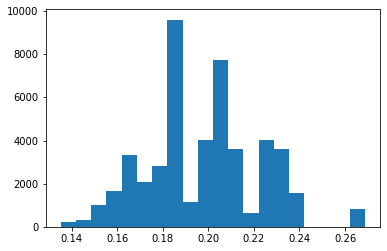

In [ ]:
plt.hist(t._NeighbourhoodRatio, bins=20)
plt.show()

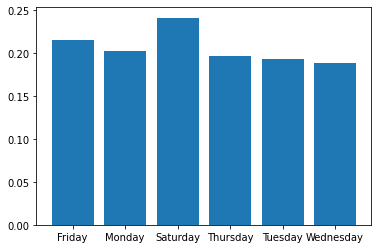

In [ ]:
plt.bar(x=transformer.day_of_week_ratio_._DayOfWeek, height=transformer.day_of_week_ratio_._DayOfWeekRatio)
plt.show()

In [ ]:
t._NoShowsRatio_xD.describe()

count   48162.0000
mean        0.0752
std         0.2407
min         0.0000
25%         0.0000
50%         0.0000
75%         0.0000
max         1.0000
Name: _NoShowsRatio_xD, dtype: float64

In [ ]:
t._RecentNoShows.value_counts()

0    42924
1     4226
2      696
3      316
Name: _RecentNoShows, dtype: int64

In [ ]:
t.sample(5, random_state=10)

,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,_waitingTime,_lastShowTime,_sumAppoint_xD,_NeighbourhoodRatio,_DayOfWeekRatio,_NoShowsRatio_xD,_RecentNoShows,_Age,_Gender,_Handcap
14079,0,0,0,0,0,4,15,0,0.2000,0.2031,0.0000,0,69,1,0
35123,0,0,0,0,1,21,15,0,0.1437,0.1934,0.0000,0,48,1,0
38786,0,0,0,0,0,0,1,1,0.2055,0.1882,0.0000,0,72,1,0
2810,0,1,0,0,0,0,0,4,0.2279,0.2149,0.2500,0,81,0,0
41600,1,0,0,0,0,13,15,0,0.1677,0.2031,0.0000,0,58,0,0


In [ ]:
t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48162 entries, 0 to 48161
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Scholarship          48162 non-null  int64  
 1   Hipertension         48162 non-null  int64  
 2   Diabetes             48162 non-null  int64  
 3   Alcoholism           48162 non-null  int64  
 4   SMS_received         48162 non-null  int64  
 5   _waitingTime         48162 non-null  int64  
 6   _lastShowTime        48162 non-null  int64  
 7   _sumAppoint_xD       48162 non-null  int64  
 8   _NeighbourhoodRatio  48162 non-null  float64
 9   _DayOfWeekRatio      48162 non-null  float64
 10  _NoShowsRatio_xD     48162 non-null  float64
 11  _RecentNoShows       48162 non-null  int64  
 12  _Age                 48162 non-null  int64  
 13  _Gender              48162 non-null  int64  
 14  _Handcap             48162 non-null  int64  
dtypes: float64(3), int64(12)
memory usag

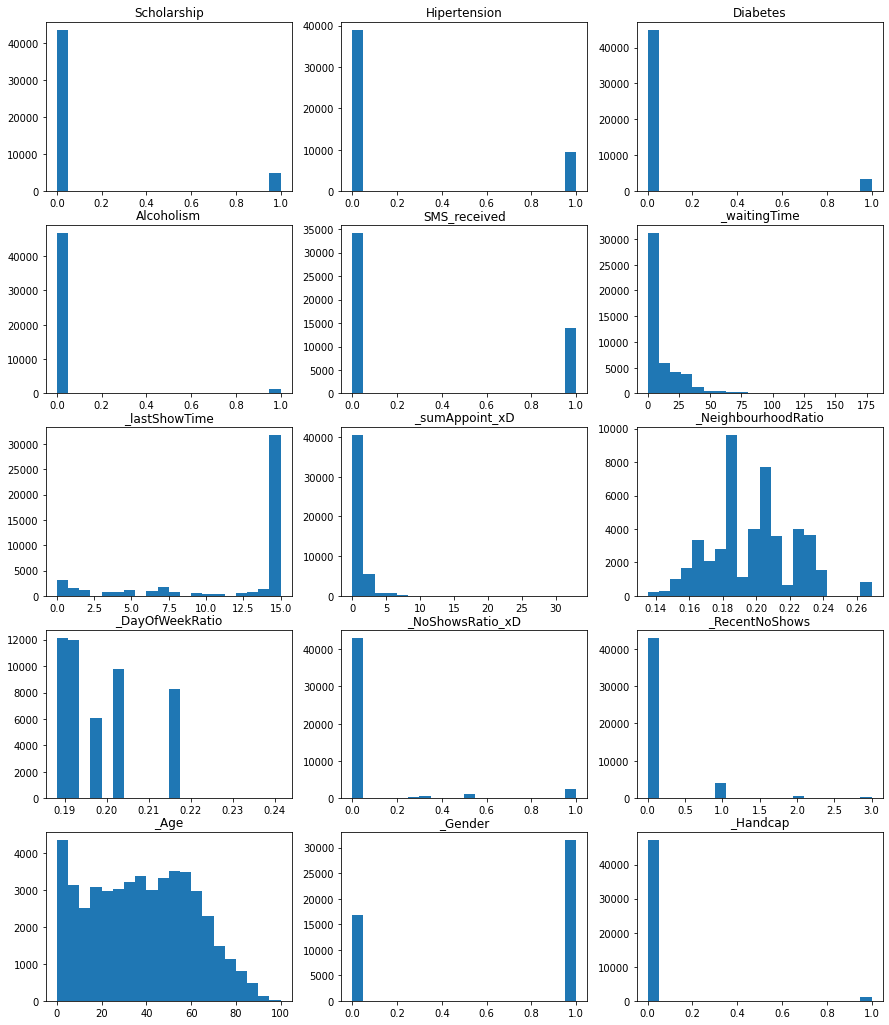

In [ ]:
fig, axs = plt.subplots(5,3,figsize=(15,18))
i, j = 0, 0
for col in [c for c in t.columns]:
    axs[i,j].hist(t[col], bins=20) 
    axs[i,j].set_title(col) 
    i = (i if j < 2 else i+1)
    j = (j+1 if j < 2 else 0)   
plt.show()

In [ ]:
print(f"Shape: {t.shape}")
sumAppoint_xD = t.loc[t['_sumAppoint_xD'] > 0, '_sumAppoint_xD'].count()
RecentNoShows = t.loc[t['_RecentNoShows'] > 0, '_RecentNoShows'].count()
print(f"Non-zero appointments in last {days_to_count} days: {sumAppoint_xD}, {100*sumAppoint_xD/t.shape[0]:.2f}%")
print(f"No-shows for recent appointments: {RecentNoShows}, {100*RecentNoShows/t.shape[0]:.2f}%")

Shape: (48162, 15)
Non-zero appointments in last 14 days: 18361, 38.12%
No-shows for recent appointments: 5238, 10.88%


### Visualization of correlations <a class="anchor" id="visualization"></a>

In [ ]:
t_y = t.join(y_train)

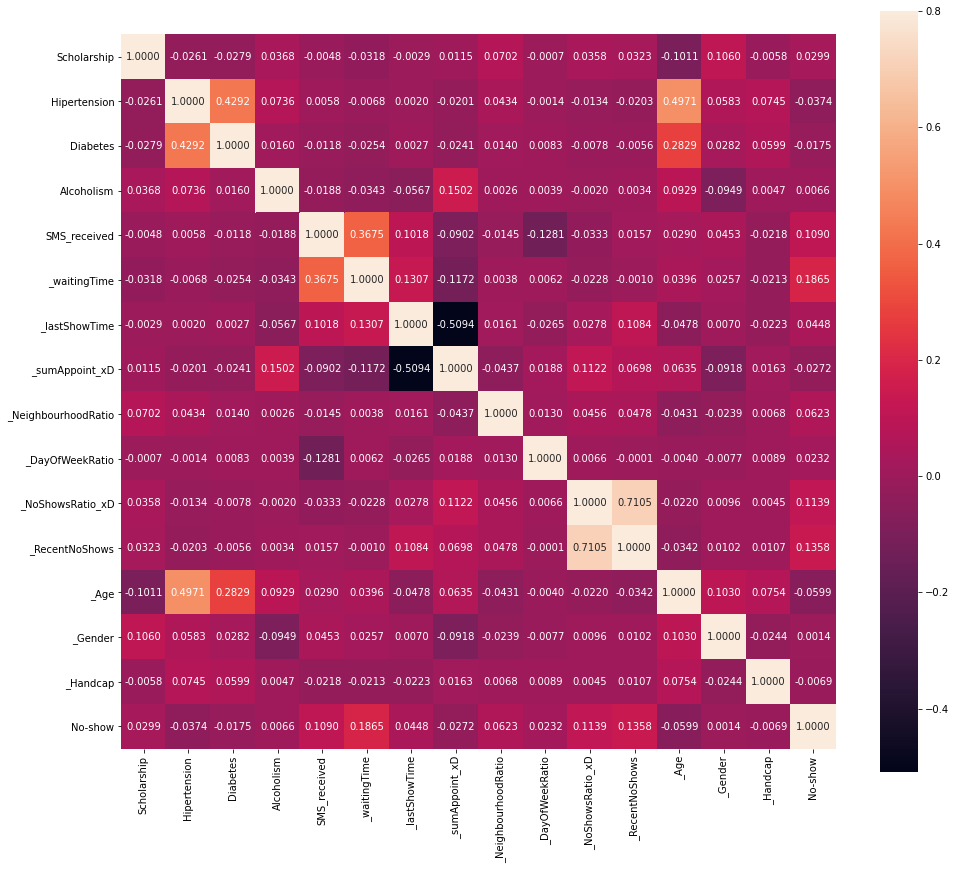

In [ ]:
# Correlation matrix
corr_matr = t_y.corr()
f, ax = plt.subplots(figsize=(16,14))
sns.heatmap(corr_matr, annot=True, fmt='.4f', vmax=.8, square=True);

### Pipeline building <a class="anchor" id="pipeline"></a>

In [ ]:
# Transformer with StandardScaler (standardizes all features to normal distribution with mean = 0 and std = 1)
custom_transformer_ss = Pipeline([
    ("custom", MedicalAppointmentsTransformer(neighbourhood_min_count = 200)),
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

In [ ]:
# Transformer with MinMaxScaler (scales all features to range [0,1])
custom_transformer_mm = Pipeline([
    ("custom", MedicalAppointmentsTransformer(neighbourhood_min_count = 200)),
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", MinMaxScaler())
])

In [ ]:
# test (doesn't change X_train)
X_train_transformed = custom_transformer_mm.fit_transform(X_train, y_train)
X_train_transformed = pd.DataFrame(X_train_transformed, columns=custom_transformer_mm.named_steps["custom"].columns)
print(X_train_transformed.shape)
X_train_transformed.head()

(48162, 15)


,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,_waitingTime,_lastShowTime,_sumAppoint_xD,_NeighbourhoodRatio,_DayOfWeekRatio,_NoShowsRatio_xD,_RecentNoShows,_Age,_Gender,_Handcap
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0168,1.0000,0.0000,0.7935,0.5026,0.0000,0.0000,0.4400,1.0000,0.0000
1,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.5261,0.0000,0.0000,0.0000,0.3900,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0168,1.0000,0.0000,0.4846,0.5026,0.0000,0.0000,0.1300,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.1850,0.2803,0.0000,0.0000,0.2800,1.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.1508,0.0667,0.0303,0.1850,0.0990,0.0000,0.0000,0.2800,1.0000,0.0000


In [ ]:
X_train_transformed.describe()

,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,_waitingTime,_lastShowTime,_sumAppoint_xD,_NeighbourhoodRatio,_DayOfWeekRatio,_NoShowsRatio_xD,_RecentNoShows,_Age,_Gender,_Handcap
count,48162.0000,48162.0000,48162.0000,48162.0000,48162.0000,48162.0000,48162.0000,48162.0000,48162.0000,48162.0000,48162.0000,48162.0000,48162.0000,48162.0000,48162.0000
mean,0.0996,0.1937,0.0700,0.0288,0.2896,0.0595,0.7845,0.0282,0.4706,0.1872,0.0752,0.0454,0.3731,0.6531,0.0206
std,0.2995,0.3952,0.2551,0.1672,0.4536,0.0881,0.3497,0.0798,0.1858,0.1736,0.2407,0.1438,0.2304,0.4760,0.1421
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5333,0.0000,0.3540,0.0000,0.0000,0.0000,0.1800,0.0000,0.0000
50%,0.0000,0.0000,0.0000,0.0000,0.0000,0.0223,1.0000,0.0000,0.4769,0.1523,0.0000,0.0000,0.3700,1.0000,0.0000
75%,0.0000,0.0000,0.0000,0.0000,1.0000,0.0894,1.0000,0.0303,0.5754,0.2803,0.0000,0.0000,0.5600,1.0000,0.0000
max,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [ ]:
# As options to check
columns_set1 = ["Scholarship", "Hipertension", "Diabetes", "Alcoholism", "SMS_received", "_waitingTime", 
               "_lastShowTime", "_sumAppoint_xD", "_NeighbourhoodRatio", "_DayOfWeekRatio", "_NoShowsRatio_xD", 
               "_RecentNoShows", "_Age", "_Gender", "_Handcap"]

columns_set2 = ["Scholarship", "Hipertension", "Diabetes", "Alcoholism", "SMS_received", "_waitingTime", 
               "_lastShowTime", "_sumAppoint_xD", "_NeighbourhoodRatio", "_DayOfWeekRatio", "_NoShowsRatio_xD", 
               "_RecentNoShows", "_Age", "_Gender", "_Handcap", "_sumNoShows_xD", "_lastNoShowTime", 
               "_sumRecentNoShows"]

## Model building and evaluation <a class="anchor" id="models"></a>

### Auxiliary classes and functions <a class="anchor" id="classes"></a>

In [ ]:
class ModelMetrics():
    """
    Calculate, print and save metrics
    """
        
    def __init__(self, y_true, y_pred):
        self.y = y_true
        self.y_pred = y_pred
        self.metrics_ = {}
        
        self.metrics_["accuracy"] = accuracy_score(y_true, y_pred)
        self.metrics_["f1"] = f1_score(y_true, y_pred)
        self.metrics_["recall"] = recall_score(y_true, y_pred)
        self.metrics_["precision"] = precision_score(y_true, y_pred)
        self.metrics_["ROC"] = roc_auc_score(y_true, y_pred)    

        
    def print_metrics(self, desc=None, with_header=True): 
        width_des, width_val = 14, 10
        format_lab = ["{:<"+str(width_des)+"}"] + ["{:>"+str(width_val)+"}"] * len(self.metrics_)
        format_val = ["{:<"+str(width_des)+"}"] + ["{:>"+str(width_val)+".4f}"] * len(self.metrics_)
        if with_header:            
            print(" | ".join(format_lab).format("", *self.metrics_.keys()))
            print("---".join(format_lab).format("-" * width_des, *["-" * width_val] * len(self.metrics_)))
        print(" | ".join(format_val).format(desc, *self.metrics_.values()))

In [ ]:
def log_experiment(exp, model_metrics, tags=None, pipe=None, columns=None):
    if tags is not None: 
        exp.append_tags(tags)
    if pipe is not None: 
        exp.log_text("pipeline steps", ','.join([step[0] for step in pipeline.steps]))
        for step in pipe.steps:
            text = ','.join([t.strip() for t in str(step[1]).split(',\n')])
            exp.log_text(f"_{step[0]}", text[:1000])      
            if len(text) > 1000:
                print(f"Warning: description of step {step[0]} exceeds length limit.")
            if step[0] == "model":
                exp.log_text(f"_{step[0]}_params", str(step[1].get_params())[:1000])
    if columns is not None: 
        exp.log_text("columns", f'[{len(columns)}] ' + ', '.join(columns)[:1000])
        if len(text) > 1000:
            print("Warning: columns list exceeds length limit.")
    for key, val in model_metrics.metrics_.items():
        exp.log_metric(key, val) 

In [ ]:
def evaluate_model(model, class_report=True, save=True, add_tags=None, final_test=False):
    steps = model.named_steps
    name = steps["model"].__class__.__name__
    scaler_name = steps["scaler"].__class__.__name__ if "scaler" in steps.keys() else "without scaler"
    over_name = steps["oversampling"].__class__.__name__ if "oversampling" in steps.keys() else "without oversampling"
    print(name, scaler_name, over_name, sep=", ")

    if save:
        my_exp = project.create_experiment(name=name)

    pipe = model.fit(X_train, y_train)        
    _y_pred = model.predict(X_train)            
    
    columns = model.named_steps["custom"].columns
    print(*columns, sep=", ")
    ModelMetrics(y_train, _y_pred).print_metrics(desc="Training set", with_header=True)

    if final_test:
        _X_test, _y_test = X_test, y_test
    else:
        _X_test, _y_test = X_valid, y_valid

    _y_pred = model.predict(_X_test)    
    model_metrics = ModelMetrics(_y_test, _y_pred)
    model_metrics.print_metrics(desc="Validation set", with_header=False)
    
    fig, ax = plt.subplots(figsize=(3, 3))
    plot_confusion_matrix(model, _X_test, _y_test, cmap='Blues', ax=ax, values_format=".0f")
    plt.show()
    
    if class_report:
        print("-" * 100)
        print("Classification report:")
        print(classification_report(_y_test, _y_pred))
        
    if save:
        my_tags = [author, name, scaler_name, over_name]
        if add_tags is not None:
            my_tags = my_tags + add_tags
        log_experiment(my_exp, model_metrics, tags=my_tags, pipe=pipe, columns=columns)
        my_exp.stop()

### Decision Tree Classifier (as example)

DecisionTreeClassifier, StandardScaler, without oversampling


Info (NVML): Driver Not Loaded. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-726
Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6095 |     0.4615 |     0.8446 |     0.3175 |     0.6980
Validation set |     0.6016 |     0.4540 |     0.8367 |     0.3115 |     0.6901


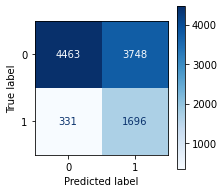

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.54      0.69      8211
           1       0.31      0.84      0.45      2027

    accuracy                           0.60     10238
   macro avg       0.62      0.69      0.57     10238
weighted avg       0.81      0.60      0.64     10238



In [ ]:
# Without balancing, with class_weight
class_weight = {0:1, 1:4} 

pipeline = Pipeline([
    ("custom", MedicalAppointmentsTransformer(neighbourhood_min_count = 200)),
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("model", DecisionTreeClassifier(max_depth=8, class_weight=class_weight, random_state=99))
])
pipeline.set_params(custom__neighbourhood_min_count = 300)
pipeline.set_params(custom__columns = columns_set2)

evaluate_model(pipeline, add_tags=["cols2"])

Balancing data for example with SMOTE using Imblearn Pipeline:

[How to Handle SMOTE Data in Imbalanced Classification Problems](https://towardsdatascience.com/how-to-handle-smote-data-in-imbalanced-classification-problems-cf4b86e8c6a1#:~:text=Just%20include%20the%20SMOTE%20process%20and%20your%20model,%3D%20make_pipeline%20%28smt%2C%20clf%29%20evaluate_model%20%28X_train%2C%20y_train%2C%20pipeline%29)

DecisionTreeClassifier, StandardScaler, SMOTETomek
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-727


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6453 |     0.4446 |     0.7167 |     0.3223 |     0.6722
Validation set |     0.6423 |     0.4407 |     0.7119 |     0.3192 |     0.6685


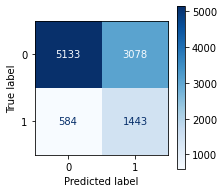

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.63      0.74      8211
           1       0.32      0.71      0.44      2027

    accuracy                           0.64     10238
   macro avg       0.61      0.67      0.59     10238
weighted avg       0.78      0.64      0.68     10238



In [ ]:
# With SMOTETomek
pipeline = Pipeline([
    ("custom", MedicalAppointmentsTransformer(neighbourhood_min_count = 200)),
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("oversampling", SMOTETomek()),
    ("model", DecisionTreeClassifier(max_depth=8, class_weight=None, random_state=99))
])
pipeline.set_params(custom__neighbourhood_min_count = 300)
pipeline.set_params(custom__columns = columns_set2)

evaluate_model(pipeline, add_tags=["cols2"])

### CatBoostClassifier
https://catboost.ai/


CatBoostClassifier, StandardScaler, SMOTETomek
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-728


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.5776 |     0.4409 |     0.8407 |     0.2988 |     0.6766
Validation set |     0.5763 |     0.4448 |     0.8574 |     0.3003 |     0.6822


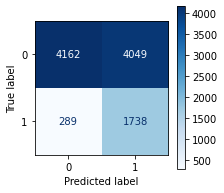

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.94      0.51      0.66      8211
           1       0.30      0.86      0.44      2027

    accuracy                           0.58     10238
   macro avg       0.62      0.68      0.55     10238
weighted avg       0.81      0.58      0.62     10238



In [ ]:
# With SMOTETomek
pipeline = Pipeline([
    ("custom", MedicalAppointmentsTransformer(neighbourhood_min_count = 200)),
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("oversampling", SMOTETomek(random_state=33)),
    ("model", CatBoostClassifier(iterations=2,
                                 depth=2,
                                 learning_rate=1,
                                 loss_function='Logloss',
                                 verbose=False, 
                                 random_state=99))
])
pipeline.set_params(custom__neighbourhood_min_count = 300)
pipeline.set_params(custom__columns = columns_set2)

evaluate_model(pipeline, add_tags=["cols2"])

CatBoostClassifier, StandardScaler, ADASYN
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-729


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.5366 |     0.4344 |     0.8981 |     0.2865 |     0.6727
Validation set |     0.5399 |     0.4379 |     0.9053 |     0.2888 |     0.6775


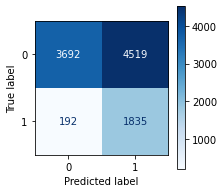

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.45      0.61      8211
           1       0.29      0.91      0.44      2027

    accuracy                           0.54     10238
   macro avg       0.62      0.68      0.52     10238
weighted avg       0.82      0.54      0.58     10238



In [ ]:
# With ADASYN
pipeline = Pipeline([
    ("custom", MedicalAppointmentsTransformer(neighbourhood_min_count = 200)),
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("oversampling", ADASYN(random_state=33)),
    ("model", CatBoostClassifier(iterations=2,
                                 depth=2,
                                 learning_rate=1,
                                 loss_function='Logloss',
                                 verbose=False, 
                                 random_state=99))
])
pipeline.set_params(custom__neighbourhood_min_count = 300)
pipeline.set_params(custom__columns = columns_set2)

evaluate_model(pipeline, add_tags=["cols2"])

### Different models (preliminary comparison)
Different models in different configurations:

LogisticRegression, MinMaxScaler, without oversampling
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-730
Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6733 |     0.4090 |     0.5706 |     0.3187 |     0.6346
Validation set |     0.6727 |     0.4091 |     0.5723 |     0.3183 |     0.6349


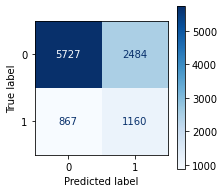

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.87      0.70      0.77      8211
           1       0.32      0.57      0.41      2027

    accuracy                           0.67     10238
   macro avg       0.59      0.63      0.59     10238
weighted avg       0.76      0.67      0.70     10238

****************************************************************************************************
LogisticRegression, MinMaxScaler, without oversampling
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-731
Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 |     

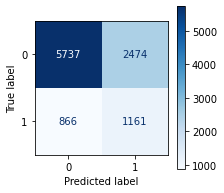

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.87      0.70      0.77      8211
           1       0.32      0.57      0.41      2027

    accuracy                           0.67     10238
   macro avg       0.59      0.64      0.59     10238
weighted avg       0.76      0.67      0.70     10238

****************************************************************************************************
LogisticRegression, StandardScaler, without oversampling
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-732
Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap
               |   accuracy |         f1 |     recall |  precision |        ROC
-----------------

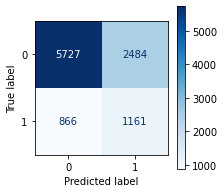

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.87      0.70      0.77      8211
           1       0.32      0.57      0.41      2027

    accuracy                           0.67     10238
   macro avg       0.59      0.64      0.59     10238
weighted avg       0.76      0.67      0.70     10238

****************************************************************************************************
LogisticRegression, StandardScaler, without oversampling
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-733
Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 |   

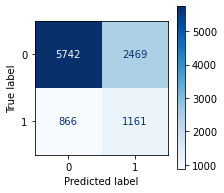

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.87      0.70      0.77      8211
           1       0.32      0.57      0.41      2027

    accuracy                           0.67     10238
   macro avg       0.59      0.64      0.59     10238
weighted avg       0.76      0.67      0.70     10238

****************************************************************************************************
LogisticRegression, MinMaxScaler, SMOTE
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-734


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6683 |     0.4113 |     0.5849 |     0.3172 |     0.6369
Validation set |     0.6676 |     0.4095 |     0.5821 |     0.3158 |     0.6354


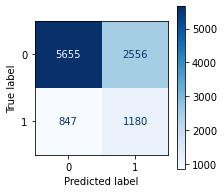

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.87      0.69      0.77      8211
           1       0.32      0.58      0.41      2027

    accuracy                           0.67     10238
   macro avg       0.59      0.64      0.59     10238
weighted avg       0.76      0.67      0.70     10238

****************************************************************************************************
LogisticRegression, MinMaxScaler, SMOTE
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-735


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6676 |     0.4126 |     0.5894 |     0.3175 |     0.6381
Validation set |     0.6680 |     0.4094 |     0.5812 |     0.3160 |     0.6353


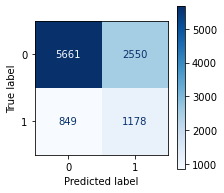

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.87      0.69      0.77      8211
           1       0.32      0.58      0.41      2027

    accuracy                           0.67     10238
   macro avg       0.59      0.64      0.59     10238
weighted avg       0.76      0.67      0.70     10238

****************************************************************************************************
LogisticRegression, StandardScaler, SMOTE
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-736


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6687 |     0.4108 |     0.5829 |     0.3171 |     0.6364
Validation set |     0.6688 |     0.4100 |     0.5812 |     0.3167 |     0.6358


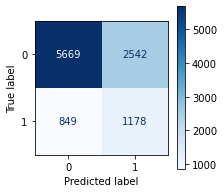

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.87      0.69      0.77      8211
           1       0.32      0.58      0.41      2027

    accuracy                           0.67     10238
   macro avg       0.59      0.64      0.59     10238
weighted avg       0.76      0.67      0.70     10238

****************************************************************************************************
LogisticRegression, StandardScaler, SMOTE
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-737


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6685 |     0.4132 |     0.5892 |     0.3182 |     0.6386
Validation set |     0.6687 |     0.4105 |     0.5826 |     0.3169 |     0.6363


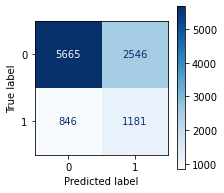

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.87      0.69      0.77      8211
           1       0.32      0.58      0.41      2027

    accuracy                           0.67     10238
   macro avg       0.59      0.64      0.59     10238
weighted avg       0.76      0.67      0.70     10238

****************************************************************************************************
LogisticRegression, MinMaxScaler, ADASYN
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-738


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6630 |     0.4118 |     0.5956 |     0.3147 |     0.6376
Validation set |     0.6629 |     0.4124 |     0.5974 |     0.3149 |     0.6383


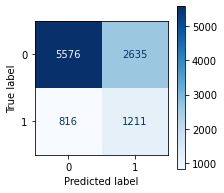

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.87      0.68      0.76      8211
           1       0.31      0.60      0.41      2027

    accuracy                           0.66     10238
   macro avg       0.59      0.64      0.59     10238
weighted avg       0.76      0.66      0.69     10238

****************************************************************************************************
LogisticRegression, MinMaxScaler, ADASYN
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-739


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6615 |     0.4132 |     0.6014 |     0.3147 |     0.6389
Validation set |     0.6630 |     0.4135 |     0.5999 |     0.3154 |     0.6393


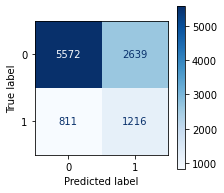

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.87      0.68      0.76      8211
           1       0.32      0.60      0.41      2027

    accuracy                           0.66     10238
   macro avg       0.59      0.64      0.59     10238
weighted avg       0.76      0.66      0.69     10238

****************************************************************************************************
LogisticRegression, StandardScaler, ADASYN
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-740


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6641 |     0.4101 |     0.5894 |     0.3145 |     0.6360
Validation set |     0.6645 |     0.4115 |     0.5925 |     0.3152 |     0.6374


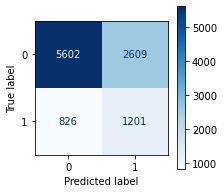

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.87      0.68      0.77      8211
           1       0.32      0.59      0.41      2027

    accuracy                           0.66     10238
   macro avg       0.59      0.64      0.59     10238
weighted avg       0.76      0.66      0.70     10238

****************************************************************************************************
LogisticRegression, StandardScaler, ADASYN
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-741


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6633 |     0.4123 |     0.5961 |     0.3152 |     0.6380
Validation set |     0.6638 |     0.4114 |     0.5935 |     0.3148 |     0.6373


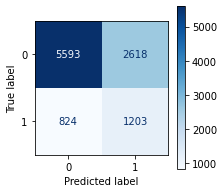

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.87      0.68      0.76      8211
           1       0.31      0.59      0.41      2027

    accuracy                           0.66     10238
   macro avg       0.59      0.64      0.59     10238
weighted avg       0.76      0.66      0.69     10238

****************************************************************************************************
DecisionTreeClassifier, MinMaxScaler, without oversampling
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-742
Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap
               |   accuracy |         f1 |     recall |  precision |        ROC
---------------

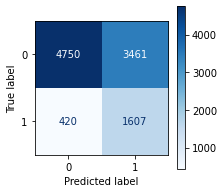

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.92      0.58      0.71      8211
           1       0.32      0.79      0.45      2027

    accuracy                           0.62     10238
   macro avg       0.62      0.69      0.58     10238
weighted avg       0.80      0.62      0.66     10238

****************************************************************************************************
DecisionTreeClassifier, MinMaxScaler, without oversampling
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-743
Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 | 

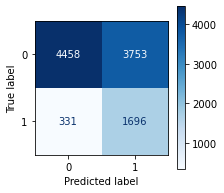

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.54      0.69      8211
           1       0.31      0.84      0.45      2027

    accuracy                           0.60     10238
   macro avg       0.62      0.69      0.57     10238
weighted avg       0.81      0.60      0.64     10238

****************************************************************************************************
DecisionTreeClassifier, StandardScaler, without oversampling
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-744
Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------

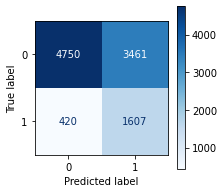

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.92      0.58      0.71      8211
           1       0.32      0.79      0.45      2027

    accuracy                           0.62     10238
   macro avg       0.62      0.69      0.58     10238
weighted avg       0.80      0.62      0.66     10238

****************************************************************************************************
DecisionTreeClassifier, StandardScaler, without oversampling
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-745
Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 

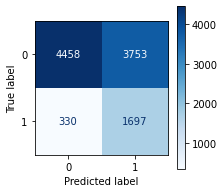

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.54      0.69      8211
           1       0.31      0.84      0.45      2027

    accuracy                           0.60     10238
   macro avg       0.62      0.69      0.57     10238
weighted avg       0.81      0.60      0.64     10238

****************************************************************************************************
DecisionTreeClassifier, MinMaxScaler, SMOTE
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-746


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6570 |     0.4385 |     0.6761 |     0.3245 |     0.6642
Validation set |     0.6518 |     0.4321 |     0.6690 |     0.3191 |     0.6583


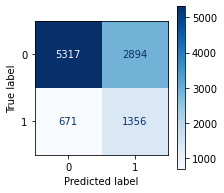

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.89      0.65      0.75      8211
           1       0.32      0.67      0.43      2027

    accuracy                           0.65     10238
   macro avg       0.60      0.66      0.59     10238
weighted avg       0.78      0.65      0.69     10238

****************************************************************************************************
DecisionTreeClassifier, MinMaxScaler, SMOTE
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-747


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6471 |     0.4419 |     0.7052 |     0.3218 |     0.6690
Validation set |     0.6400 |     0.4352 |     0.7005 |     0.3156 |     0.6628


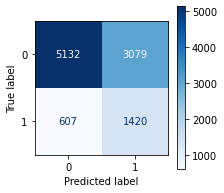

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.89      0.63      0.74      8211
           1       0.32      0.70      0.44      2027

    accuracy                           0.64     10238
   macro avg       0.60      0.66      0.59     10238
weighted avg       0.78      0.64      0.68     10238

****************************************************************************************************
DecisionTreeClassifier, StandardScaler, SMOTE
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-748


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6449 |     0.4456 |     0.7204 |     0.3226 |     0.6733
Validation set |     0.6378 |     0.4360 |     0.7070 |     0.3152 |     0.6639


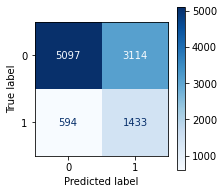

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.62      0.73      8211
           1       0.32      0.71      0.44      2027

    accuracy                           0.64     10238
   macro avg       0.61      0.66      0.58     10238
weighted avg       0.78      0.64      0.67     10238

****************************************************************************************************
DecisionTreeClassifier, StandardScaler, SMOTE
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-749


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6949 |     0.4443 |     0.6156 |     0.3476 |     0.6650
Validation set |     0.6905 |     0.4352 |     0.6024 |     0.3407 |     0.6573


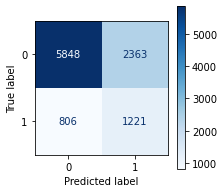

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.71      0.79      8211
           1       0.34      0.60      0.44      2027

    accuracy                           0.69     10238
   macro avg       0.61      0.66      0.61     10238
weighted avg       0.77      0.69      0.72     10238

****************************************************************************************************
DecisionTreeClassifier, MinMaxScaler, ADASYN
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-750


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6539 |     0.4406 |     0.6881 |     0.3241 |     0.6668
Validation set |     0.6484 |     0.4332 |     0.6788 |     0.3182 |     0.6598


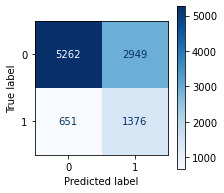

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.89      0.64      0.75      8211
           1       0.32      0.68      0.43      2027

    accuracy                           0.65     10238
   macro avg       0.60      0.66      0.59     10238
weighted avg       0.78      0.65      0.68     10238

****************************************************************************************************
DecisionTreeClassifier, MinMaxScaler, ADASYN
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-751


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6448 |     0.4435 |     0.7144 |     0.3216 |     0.6710
Validation set |     0.6381 |     0.4358 |     0.7060 |     0.3152 |     0.6637


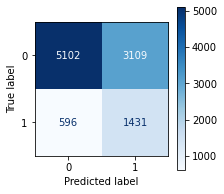

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.62      0.73      8211
           1       0.32      0.71      0.44      2027

    accuracy                           0.64     10238
   macro avg       0.61      0.66      0.58     10238
weighted avg       0.78      0.64      0.67     10238

****************************************************************************************************
DecisionTreeClassifier, StandardScaler, ADASYN
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-752


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6546 |     0.4387 |     0.6813 |     0.3235 |     0.6647
Validation set |     0.6498 |     0.4312 |     0.6704 |     0.3178 |     0.6576


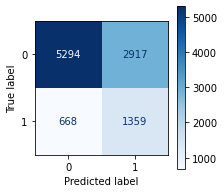

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.89      0.64      0.75      8211
           1       0.32      0.67      0.43      2027

    accuracy                           0.65     10238
   macro avg       0.60      0.66      0.59     10238
weighted avg       0.78      0.65      0.68     10238

****************************************************************************************************
DecisionTreeClassifier, StandardScaler, ADASYN
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-753


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6552 |     0.4409 |     0.6862 |     0.3248 |     0.6669
Validation set |     0.6514 |     0.4347 |     0.6769 |     0.3201 |     0.6610


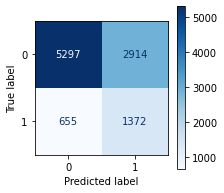

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.89      0.65      0.75      8211
           1       0.32      0.68      0.43      2027

    accuracy                           0.65     10238
   macro avg       0.61      0.66      0.59     10238
weighted avg       0.78      0.65      0.69     10238

****************************************************************************************************
RandomForestClassifier, MinMaxScaler, without oversampling
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-754
Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap
               |   accuracy |         f1 |     recall |  precision |        ROC
---------------

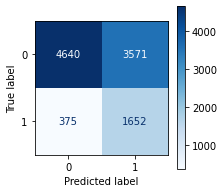

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.57      0.70      8211
           1       0.32      0.81      0.46      2027

    accuracy                           0.61     10238
   macro avg       0.62      0.69      0.58     10238
weighted avg       0.80      0.61      0.65     10238

****************************************************************************************************
RandomForestClassifier, MinMaxScaler, without oversampling
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-755
Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 | 

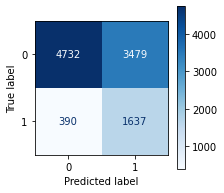

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.92      0.58      0.71      8211
           1       0.32      0.81      0.46      2027

    accuracy                           0.62     10238
   macro avg       0.62      0.69      0.58     10238
weighted avg       0.80      0.62      0.66     10238

****************************************************************************************************
RandomForestClassifier, StandardScaler, without oversampling
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-756
Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------

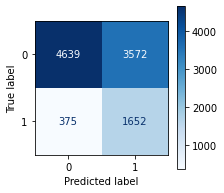

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.56      0.70      8211
           1       0.32      0.81      0.46      2027

    accuracy                           0.61     10238
   macro avg       0.62      0.69      0.58     10238
weighted avg       0.80      0.61      0.65     10238

****************************************************************************************************
RandomForestClassifier, StandardScaler, without oversampling
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-757
Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 

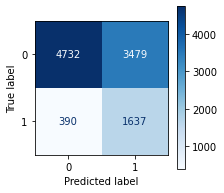

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.92      0.58      0.71      8211
           1       0.32      0.81      0.46      2027

    accuracy                           0.62     10238
   macro avg       0.62      0.69      0.58     10238
weighted avg       0.80      0.62      0.66     10238

****************************************************************************************************
RandomForestClassifier, MinMaxScaler, SMOTE
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-758


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6204 |     0.4619 |     0.8224 |     0.3212 |     0.6964
Validation set |     0.6172 |     0.4556 |     0.8091 |     0.3171 |     0.6895


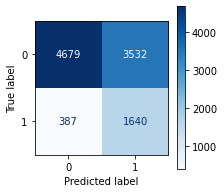

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.92      0.57      0.70      8211
           1       0.32      0.81      0.46      2027

    accuracy                           0.62     10238
   macro avg       0.62      0.69      0.58     10238
weighted avg       0.80      0.62      0.66     10238

****************************************************************************************************
RandomForestClassifier, MinMaxScaler, SMOTE
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-759


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6197 |     0.4603 |     0.8188 |     0.3202 |     0.6946
Validation set |     0.6184 |     0.4564 |     0.8091 |     0.3178 |     0.6902


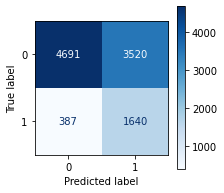

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.92      0.57      0.71      8211
           1       0.32      0.81      0.46      2027

    accuracy                           0.62     10238
   macro avg       0.62      0.69      0.58     10238
weighted avg       0.80      0.62      0.66     10238

****************************************************************************************************
RandomForestClassifier, StandardScaler, SMOTE
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-760


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6226 |     0.4607 |     0.8136 |     0.3213 |     0.6945
Validation set |     0.6198 |     0.4547 |     0.8007 |     0.3176 |     0.6879


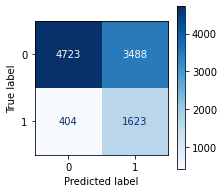

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.92      0.58      0.71      8211
           1       0.32      0.80      0.45      2027

    accuracy                           0.62     10238
   macro avg       0.62      0.69      0.58     10238
weighted avg       0.80      0.62      0.66     10238

****************************************************************************************************
RandomForestClassifier, StandardScaler, SMOTE
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-761


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6112 |     0.4578 |     0.8283 |     0.3163 |     0.6930
Validation set |     0.6111 |     0.4548 |     0.8194 |     0.3148 |     0.6895


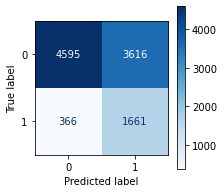

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.56      0.70      8211
           1       0.31      0.82      0.45      2027

    accuracy                           0.61     10238
   macro avg       0.62      0.69      0.58     10238
weighted avg       0.81      0.61      0.65     10238

****************************************************************************************************
RandomForestClassifier, MinMaxScaler, ADASYN
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-762


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6069 |     0.4587 |     0.8405 |     0.3154 |     0.6949
Validation set |     0.6055 |     0.4534 |     0.8263 |     0.3124 |     0.6887


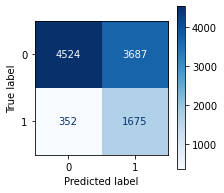

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.55      0.69      8211
           1       0.31      0.83      0.45      2027

    accuracy                           0.61     10238
   macro avg       0.62      0.69      0.57     10238
weighted avg       0.81      0.61      0.64     10238

****************************************************************************************************
RandomForestClassifier, MinMaxScaler, ADASYN
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-763


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6140 |     0.4593 |     0.8275 |     0.3179 |     0.6944
Validation set |     0.6126 |     0.4549 |     0.8165 |     0.3153 |     0.6894


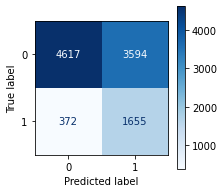

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.56      0.70      8211
           1       0.32      0.82      0.45      2027

    accuracy                           0.61     10238
   macro avg       0.62      0.69      0.58     10238
weighted avg       0.80      0.61      0.65     10238

****************************************************************************************************
RandomForestClassifier, StandardScaler, ADASYN
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-764


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6059 |     0.4580 |     0.8406 |     0.3148 |     0.6942
Validation set |     0.6042 |     0.4512 |     0.8219 |     0.3110 |     0.6862


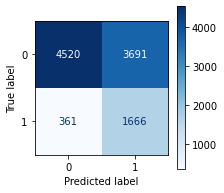

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.55      0.69      8211
           1       0.31      0.82      0.45      2027

    accuracy                           0.60     10238
   macro avg       0.62      0.69      0.57     10238
weighted avg       0.80      0.60      0.64     10238

****************************************************************************************************
RandomForestClassifier, StandardScaler, ADASYN
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-765


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6051 |     0.4558 |     0.8345 |     0.3135 |     0.6915
Validation set |     0.6075 |     0.4554 |     0.8288 |     0.3140 |     0.6909


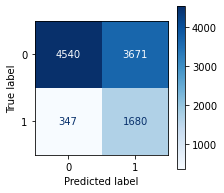

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.55      0.69      8211
           1       0.31      0.83      0.46      2027

    accuracy                           0.61     10238
   macro avg       0.62      0.69      0.57     10238
weighted avg       0.81      0.61      0.65     10238

****************************************************************************************************
CatBoostClassifier, MinMaxScaler, without oversampling
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-766
Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------

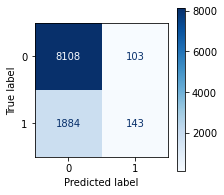

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      8211
           1       0.58      0.07      0.13      2027

    accuracy                           0.81     10238
   macro avg       0.70      0.53      0.51     10238
weighted avg       0.77      0.81      0.74     10238

****************************************************************************************************
CatBoostClassifier, MinMaxScaler, without oversampling
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-767
Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 |     

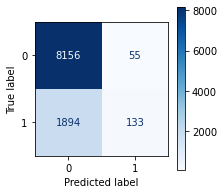

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      8211
           1       0.71      0.07      0.12      2027

    accuracy                           0.81     10238
   macro avg       0.76      0.53      0.51     10238
weighted avg       0.79      0.81      0.74     10238

****************************************************************************************************
CatBoostClassifier, StandardScaler, without oversampling
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-768
Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap
               |   accuracy |         f1 |     recall |  precision |        ROC
-----------------

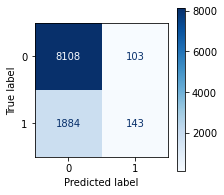

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      8211
           1       0.58      0.07      0.13      2027

    accuracy                           0.81     10238
   macro avg       0.70      0.53      0.51     10238
weighted avg       0.77      0.81      0.74     10238

****************************************************************************************************
CatBoostClassifier, StandardScaler, without oversampling
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-769
Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 |   

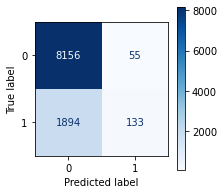

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      8211
           1       0.71      0.07      0.12      2027

    accuracy                           0.81     10238
   macro avg       0.76      0.53      0.51     10238
weighted avg       0.79      0.81      0.74     10238

****************************************************************************************************
CatBoostClassifier, MinMaxScaler, SMOTE
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-770


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6586 |     0.4421 |     0.6828 |     0.3269 |     0.6677
Validation set |     0.6588 |     0.4428 |     0.6848 |     0.3272 |     0.6686


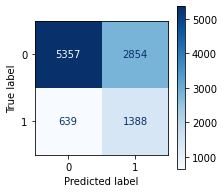

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.89      0.65      0.75      8211
           1       0.33      0.68      0.44      2027

    accuracy                           0.66     10238
   macro avg       0.61      0.67      0.60     10238
weighted avg       0.78      0.66      0.69     10238

****************************************************************************************************
CatBoostClassifier, MinMaxScaler, SMOTE
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-771


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6694 |     0.4485 |     0.6786 |     0.3349 |     0.6728
Validation set |     0.6711 |     0.4510 |     0.6823 |     0.3368 |     0.6753


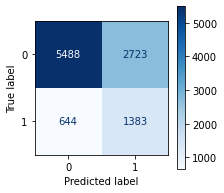

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.89      0.67      0.77      8211
           1       0.34      0.68      0.45      2027

    accuracy                           0.67     10238
   macro avg       0.62      0.68      0.61     10238
weighted avg       0.78      0.67      0.70     10238

****************************************************************************************************
CatBoostClassifier, StandardScaler, SMOTE
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-772


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6681 |     0.4445 |     0.6702 |     0.3325 |     0.6689
Validation set |     0.6656 |     0.4425 |     0.6704 |     0.3303 |     0.6674


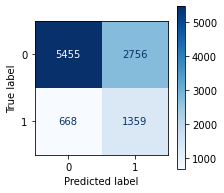

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.89      0.66      0.76      8211
           1       0.33      0.67      0.44      2027

    accuracy                           0.67     10238
   macro avg       0.61      0.67      0.60     10238
weighted avg       0.78      0.67      0.70     10238

****************************************************************************************************
CatBoostClassifier, StandardScaler, SMOTE
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-773


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6451 |     0.4513 |     0.7367 |     0.3253 |     0.6796
Validation set |     0.6425 |     0.4475 |     0.7311 |     0.3224 |     0.6759


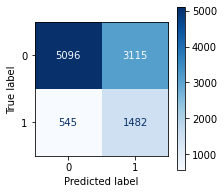

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.62      0.74      8211
           1       0.32      0.73      0.45      2027

    accuracy                           0.64     10238
   macro avg       0.61      0.68      0.59     10238
weighted avg       0.79      0.64      0.68     10238

****************************************************************************************************
CatBoostClassifier, MinMaxScaler, ADASYN
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-774


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6664 |     0.4336 |     0.6444 |     0.3267 |     0.6581
Validation set |     0.6725 |     0.4411 |     0.6527 |     0.3331 |     0.6650


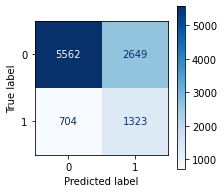

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.89      0.68      0.77      8211
           1       0.33      0.65      0.44      2027

    accuracy                           0.67     10238
   macro avg       0.61      0.67      0.60     10238
weighted avg       0.78      0.67      0.70     10238

****************************************************************************************************
CatBoostClassifier, MinMaxScaler, ADASYN
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-775


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6507 |     0.4352 |     0.6792 |     0.3202 |     0.6614
Validation set |     0.6525 |     0.4368 |     0.6808 |     0.3216 |     0.6631


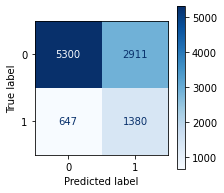

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.89      0.65      0.75      8211
           1       0.32      0.68      0.44      2027

    accuracy                           0.65     10238
   macro avg       0.61      0.66      0.59     10238
weighted avg       0.78      0.65      0.69     10238

****************************************************************************************************
CatBoostClassifier, StandardScaler, ADASYN
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-776


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6332 |     0.4412 |     0.7309 |     0.3160 |     0.6700
Validation set |     0.6358 |     0.4437 |     0.7336 |     0.3180 |     0.6726


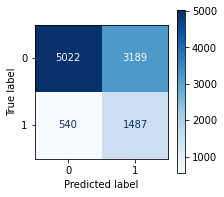

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.61      0.73      8211
           1       0.32      0.73      0.44      2027

    accuracy                           0.64     10238
   macro avg       0.61      0.67      0.59     10238
weighted avg       0.79      0.64      0.67     10238

****************************************************************************************************
CatBoostClassifier, StandardScaler, ADASYN
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-777


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.6441 |     0.4453 |     0.7211 |     0.3221 |     0.6731
Validation set |     0.6446 |     0.4455 |     0.7213 |     0.3223 |     0.6734


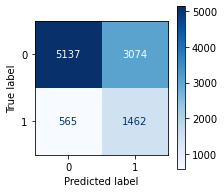

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.63      0.74      8211
           1       0.32      0.72      0.45      2027

    accuracy                           0.64     10238
   macro avg       0.61      0.67      0.59     10238
weighted avg       0.79      0.64      0.68     10238

****************************************************************************************************
XGBClassifier, MinMaxScaler, without oversampling
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-778
Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap
               |   accuracy |         f1 |     recall |  precision |        ROC
------------------------

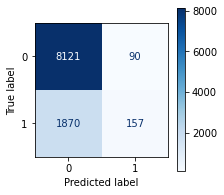

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      8211
           1       0.64      0.08      0.14      2027

    accuracy                           0.81     10238
   macro avg       0.72      0.53      0.52     10238
weighted avg       0.78      0.81      0.74     10238

****************************************************************************************************
XGBClassifier, MinMaxScaler, without oversampling
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-779
Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 |     recal

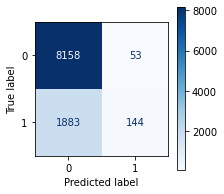

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      8211
           1       0.73      0.07      0.13      2027

    accuracy                           0.81     10238
   macro avg       0.77      0.53      0.51     10238
weighted avg       0.80      0.81      0.74     10238

****************************************************************************************************
XGBClassifier, StandardScaler, without oversampling
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-780
Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap
               |   accuracy |         f1 |     recall |  precision |        ROC
----------------------

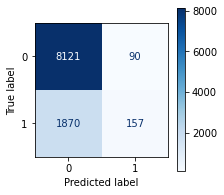

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      8211
           1       0.64      0.08      0.14      2027

    accuracy                           0.81     10238
   macro avg       0.72      0.53      0.52     10238
weighted avg       0.78      0.81      0.74     10238

****************************************************************************************************
XGBClassifier, StandardScaler, without oversampling
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-781
Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 |     rec

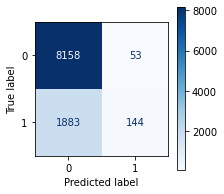

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      8211
           1       0.73      0.07      0.13      2027

    accuracy                           0.81     10238
   macro avg       0.77      0.53      0.51     10238
weighted avg       0.80      0.81      0.74     10238

****************************************************************************************************
XGBClassifier, MinMaxScaler, SMOTE
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-782


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.7564 |     0.4368 |     0.4768 |     0.4030 |     0.6512
Validation set |     0.7500 |     0.4145 |     0.4470 |     0.3864 |     0.6359


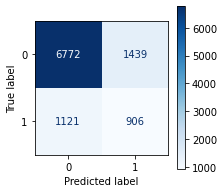

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      8211
           1       0.39      0.45      0.41      2027

    accuracy                           0.75     10238
   macro avg       0.62      0.64      0.63     10238
weighted avg       0.76      0.75      0.76     10238

****************************************************************************************************
XGBClassifier, MinMaxScaler, SMOTE
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-783


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.7549 |     0.4355 |     0.4773 |     0.4005 |     0.6504
Validation set |     0.7462 |     0.4109 |     0.4470 |     0.3802 |     0.6335


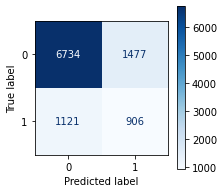

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      8211
           1       0.38      0.45      0.41      2027

    accuracy                           0.75     10238
   macro avg       0.62      0.63      0.62     10238
weighted avg       0.76      0.75      0.75     10238

****************************************************************************************************
XGBClassifier, StandardScaler, SMOTE
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-784


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.7568 |     0.4421 |     0.4864 |     0.4053 |     0.6550
Validation set |     0.7452 |     0.4109 |     0.4489 |     0.3789 |     0.6336


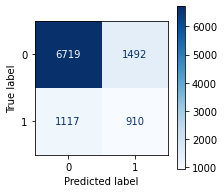

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      8211
           1       0.38      0.45      0.41      2027

    accuracy                           0.75     10238
   macro avg       0.62      0.63      0.62     10238
weighted avg       0.76      0.75      0.75     10238

****************************************************************************************************
XGBClassifier, StandardScaler, SMOTE
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-785


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.7552 |     0.4431 |     0.4915 |     0.4034 |     0.6559
Validation set |     0.7443 |     0.4138 |     0.4558 |     0.3788 |     0.6357


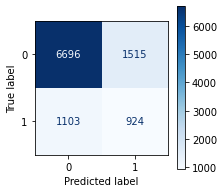

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      8211
           1       0.38      0.46      0.41      2027

    accuracy                           0.74     10238
   macro avg       0.62      0.64      0.63     10238
weighted avg       0.76      0.74      0.75     10238

****************************************************************************************************
XGBClassifier, MinMaxScaler, ADASYN
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-786


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.7514 |     0.4350 |     0.4831 |     0.3956 |     0.6504
Validation set |     0.7444 |     0.4152 |     0.4583 |     0.3795 |     0.6367


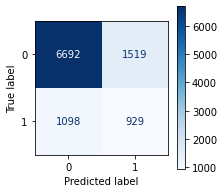

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      8211
           1       0.38      0.46      0.42      2027

    accuracy                           0.74     10238
   macro avg       0.62      0.64      0.63     10238
weighted avg       0.76      0.74      0.75     10238

****************************************************************************************************
XGBClassifier, MinMaxScaler, ADASYN
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-787


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.7539 |     0.4365 |     0.4810 |     0.3995 |     0.6512
Validation set |     0.7455 |     0.4066 |     0.4406 |     0.3776 |     0.6306


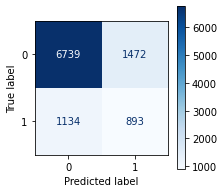

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      8211
           1       0.38      0.44      0.41      2027

    accuracy                           0.75     10238
   macro avg       0.62      0.63      0.62     10238
weighted avg       0.76      0.75      0.75     10238

****************************************************************************************************
XGBClassifier, StandardScaler, ADASYN
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-788


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.7512 |     0.4395 |     0.4923 |     0.3969 |     0.6537
Validation set |     0.7449 |     0.4162 |     0.4593 |     0.3805 |     0.6373


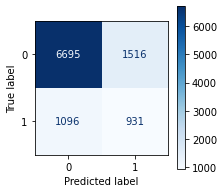

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      8211
           1       0.38      0.46      0.42      2027

    accuracy                           0.74     10238
   macro avg       0.62      0.64      0.63     10238
weighted avg       0.76      0.74      0.75     10238

****************************************************************************************************
XGBClassifier, StandardScaler, ADASYN
https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-789


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, _waitingTime, _lastShowTime, _sumAppoint_xD, _NeighbourhoodRatio, _DayOfWeekRatio, _NoShowsRatio_xD, _RecentNoShows, _Age, _Gender, _Handcap, _sumNoShows_xD, _lastNoShowTime, _sumRecentNoShows
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |     0.7515 |     0.4389 |     0.4906 |     0.3971 |     0.6533
Validation set |     0.7443 |     0.4127 |     0.4539 |     0.3784 |     0.6349


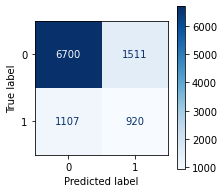

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      8211
           1       0.38      0.45      0.41      2027

    accuracy                           0.74     10238
   macro avg       0.62      0.63      0.62     10238
weighted avg       0.76      0.74      0.75     10238

****************************************************************************************************


In [ ]:
class_weight = {0:1, 1:4} # only for models without balancing

custom_transformer = MedicalAppointmentsTransformer(neighbourhood_min_count=300)
imputer = SimpleImputer(strategy="mean")

models = []
models.append(LogisticRegression(max_iter=1000, random_state=33))
models.append(DecisionTreeClassifier(max_depth=8, random_state=33))
models.append(RandomForestClassifier(max_depth=8, n_estimators=100, random_state=33))
models.append(CatBoostClassifier(iterations=4, max_depth=4, learning_rate=1, loss_function='Logloss', 
                                 verbose=False, random_state=33))
models.append(XGBClassifier(booster="gbtree", eta=0.5, max_depth=5, random_state=33))

overs = []
overs.append(None)
overs.append(SMOTE(random_state=33))
overs.append(ADASYN(random_state=33))

scalers = []
scalers.append(MinMaxScaler())
scalers.append(StandardScaler())

columns_set_dict = {"cols1": columns_set1, "cols2": columns_set2}

for model in models:
    for over in overs:
        for scaler in scalers:
            for cols_set_key, cols_set in columns_set_dict.items():
                steps = []
                steps.append(("custom", custom_transformer))
                steps.append(("imputer", imputer))
                steps.append(("scaler", scaler))
                if over is not None: 
                    steps.append(("oversampling", over))
                steps.append(("model", model))
                pipeline = Pipeline(steps)

                if isinstance(model, LogisticRegression) or \
                   isinstance(model, DecisionTreeClassifier) or \
                   isinstance(model, RandomForestClassifier):
                    pipeline.set_params(model__class_weight=(class_weight if over is None else None))
                pipeline.set_params(custom__columns = cols_set)

                evaluate_model(pipeline, add_tags=[cols_set_key])
                print("*"*100)

### The choice of model & hyperparameters

In [ ]:
"""
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
grid = GridSearchCV(pipeline,
                    scoring = "recall",
                    param_grid={"model__eta": [0.1, 0.2, 0.3],
                                "model__max_depth": [3, 6, 9],
                                "custom_transformer__custom__neighbourhood_min_count": [300]}, 
                    cv=kfold, n_jobs=4)

grid_search_results = grid.fit(X_train, y_train)
print("The best parameters:\r\n", grid_search_results.best_params_)  
"""
print()

## Final evaluation <a class="anchor" id="final"></a>

In [ ]:
"""
class_weight = {0:1, 1:4} 

pipeline = Pipeline([
    ("custom", MedicalAppointmentsTransformer(neighbourhood_min_count = 200)),
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("model", DecisionTreeClassifier(max_depth=8, class_weight=class_weight, random_state=99))
])
pipeline.set_params(custom__neighbourhood_min_count = 300)
pipeline.set_params(custom__columns = columns_set2)

evaluate_model(pipeline, add_tags=["cols2", "final"], final_test=True)
"""

'\nclass_weight = {0:1, 1:4} \n\npipeline = Pipeline([\n    ("custom", MedicalAppointmentsTransformer(neighbourhood_min_count = 200)),\n    ("imputer", SimpleImputer(strategy="mean")),\n    ("scaler", StandardScaler()),\n    ("model", DecisionTreeClassifier(max_depth=8, class_weight=class_weight, random_state=99))\n])\npipeline.set_params(custom__neighbourhood_min_count = 300)\npipeline.set_params(custom__columns = columns_set2)\n\nevaluate_model(pipeline, add_tags=["cols2", "final"], final_test=True)\n'

## Summary <a class="anchor" id="summary"></a>